In [1]:
import hoomd

In [2]:
import numpy
device = hoomd.device.CPU()
seed = numpy.random.randint(1,1e4)
simulation = hoomd.Simulation(device = device, seed = seed)

In [3]:
kT = 1.0
epsilon = 1.0
sigma = 1.0
final_density = 1.0

In [58]:
import freud
starting_density = 0.5
#a is the spacing between particles
a = 1/(starting_density**(1/3.0))
#We want a number of particles N in our system.
#Since we will be replicating the system in 3 dimensions, the number of unit cells we need is N^(1/3)
num_replicas = 27
N_particles = num_replicas**3
grid_particles = freud.data.UnitCell([a,a,a,0,0,0],[[0,0,0]]).generate_system(num_replicas)
box_length = grid_particles[0].Lx
print(box_length)

34.01786804199219


In [59]:
import gsd.hoomd
frame = gsd.hoomd.Frame()
frame.particles.N = N_particles
frame.particles.position = grid_particles[1]
frame.configuration.box = [box_length,box_length,box_length,0,0,0]

#Types of particles define different interactions. In an atomistic simulation these might be C, O, and H.
#in a coarse-grained simulation we can give them a simple name like A
frame.particles.typeid = [0]*N_particles
frame.particles.types = ['A']

#Finally, save our initial state:
with gsd.hoomd.open(name='initial_state_27.gsd', mode='w') as f:
    f.append(frame)

In [14]:
simulation.create_state_from_gsd(filename='initial_state.gsd')

RuntimeError: Cannot initialize more than once


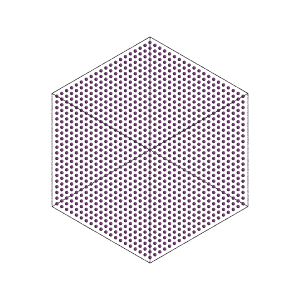

In [7]:
from cmeutils.visualize import FresnelGSD

sim_visualizer = FresnelGSD(
    gsd_file="initial_state.gsd", frame=0, view_axis=(1, 1, 1)
)
sim_visualizer.view()

In [67]:
dt = 0.005
T = [0.5,0.6,0.7,0.8,0.9,1.0,1.25,1.5,1.75,2.0]
pe_temp_runs = {}
ke_temp_runs = {}
positions = []
for i in T:
  del simulation
  print(i)
  pe_temp_runs[f"{i}"] = []
  ke_temp_runs[f"{i}"] = []
  simulation = hoomd.Simulation(device = device, seed = seed)
  simulation.create_state_from_gsd(filename='initial_state_10.gsd')
  integrator = hoomd.md.Integrator(dt = dt)
  nvt = hoomd.md.methods.NVT(filter = hoomd.filter.All(),kT=i,tau=100*dt)
  integrator.methods.append(nvt)
  cell = hoomd.md.nlist.Cell(buffer=0.4)

  #Define the force for different particles
  lj = hoomd.md.pair.LJ(nlist=cell)

  lj.params[('A', 'A')] = {"epsilon":epsilon, "sigma":sigma}

  lj.r_cut[('A', 'A')] = 2.5*sigma
  integrator.forces.append(lj)
  simulation.operations.integrator = integrator
  simulation.run(10)

  simulation.state.thermalize_particle_momenta(filter=hoomd.filter.All(), kT=i)
  thermodynamic_properties = hoomd.md.compute.ThermodynamicQuantities(
      filter=hoomd.filter.All()
  )

  simulation.operations.computes.append(thermodynamic_properties)
  logger = hoomd.logging.Logger(categories=['scalar', 'sequence'])
  logger.add(simulation)
  logger.add(thermodynamic_properties,quantities=['potential_energy'])
  gsd_writer = hoomd.write.GSD(filename='log_T_'+str(i)+'.gsd',
                             trigger=hoomd.trigger.Periodic(1000),
                             mode='xb')
  simulation.operations.writers.append(gsd_writer)
  gsd_writer.log = logger
  tps_tracking = hoomd.logging.Logger(categories=['scalar', 'string'])
  tps_tracking.add(simulation, quantities=['timestep', 'tps'])
  table = hoomd.write.Table(trigger=hoomd.trigger.Periodic(period=int(1e4)), logger=tps_tracking)
  simulation.operations.writers.append(table)
  for step in range(10000):
      simulation.run(10)
      pe_temp_runs[f"{i}"].append(thermodynamic_properties.potential_energy)
      ke_temp_runs[f"{i}"].append(thermodynamic_properties.kinetic_energy)
  snapshot = simulation.state.get_snapshot()
  positions.append(snapshot.particles.position)

0.5


/Users/stephaniemccallum/miniforge3/envs/mdproject/lib/python3.11/site-packages/hoomd/write/gsd.py:286: FutureWarning: log property is deprecated since v3.9.0. Use logger instead.
  warnings.warn(


Simulation.timestep  Simulation.tps 
       10000           1611.45927   
       20000           3060.18361   
       30000           1573.15155   
       40000           1580.05618   
       50000           2956.63601   
       60000           1582.27848   
       70000           1551.72414   
       80000           1543.20988   
       90000           1571.22905   
      100000           3035.41315   
0.6
Simulation.timestep  Simulation.tps 
       10000           1677.22698   
       20000           1659.59801   
       30000           3252.62017   
       40000           1609.44206   
       50000           1626.89805   
       60000           1566.85237   
       70000           1599.71561   
       80000           1588.14187   
       90000           1584.50704   
      100000           1592.92035   
0.7
Simulation.timestep  Simulation.tps 
       10000           1879.30674   
       20000           1579.50158   
       30000           3437.73873   
       40000           1736.11

In [ ]:
def autocorr1D(array):
    """Takes in a linear np array, performs autocorrelation
    function and returns normalized array with half the length
    of the input.

    Parameters
    ----------
    data : numpy.typing.Arraylike, required
        1-D series of data to perform autocorrelation on.

    Returns
    -------
    1D np.array

    """
    ft = numpy.fft.rfft(array - numpy.average(array))
    acorr = numpy.fft.irfft(ft * numpy.conjugate(ft)) / (len(array) * numpy.var(array))
    return acorr[0 : len(acorr) // 2]  # noqa: E203

In [ ]:
a = autocorr1D(s.energies[25000:])
plt.plot(a)
print(numpy.where(a <= 0)[0][:10])
decorrelation_time = numpy.where(a <= 0)[0][0]
independent_samples = (600000-25000)/decorrelation_time
print("Decorrelation time", decorrelation_time, " Number of independent samples:",independent_samples)

In [ ]:
# calculate radial distribution function
def rdf(coordinates,rho, Rmax=8,deltaR=.05):#units of sigma
  #initialize an empty array with
  nbins = Rmax//deltaR
  rdf = np.zeros(nbins)

  #loop over pairs
  for i,pi in enumerate(coordinates[:-1]):
    for j,pj in enumerate(coordinates[i+1:]):
      d = numpy.linalg.norm(pj-pi)
      index = d//deltaR
      rdf[index] += 1 #increment bins

  #normalize each bin by volume of annulus and number density
  for i,bin in enumerate(rdf):
    r=i*deltaR
    N = len(coordinates)
    #need rho
    v = rho*N*((r+deltaR)**3 - r**3)*4*numpy.pi/6 #just missing N and density
    rdf[i] = bin/v
  return rdf

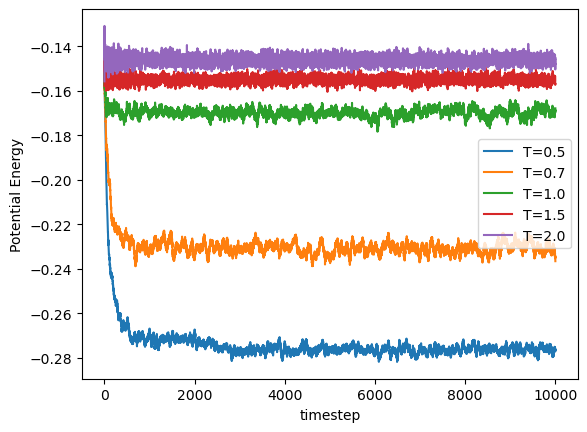

In [64]:
import matplotlib.pyplot as plt
for T, e in pe_temp_runs.items():
  plt.plot(numpy.array(e[0:])/N_particles, label=f'T={T}')
plt.xlabel('timestep')
plt.ylabel('Potential Energy')
plt.legend()

In [24]:
for T, e in pe_temp_runs.items():
  plt.plot(numpy.array(e[0:])/N_particles, label=f'T={T}')
plt.xlabel('timestep')
plt.ylabel('Potential Energy')
plt.legend()

ValueError: too many values to unpack (expected 2)

I ran into some issues running dt = 0.05. The error is related to a particle out of box, which is surprising with a lattice system and periodic boundary conditions.

Based on the other dt, as the step size decreases, the system relaxes to equillibrium more slowly.

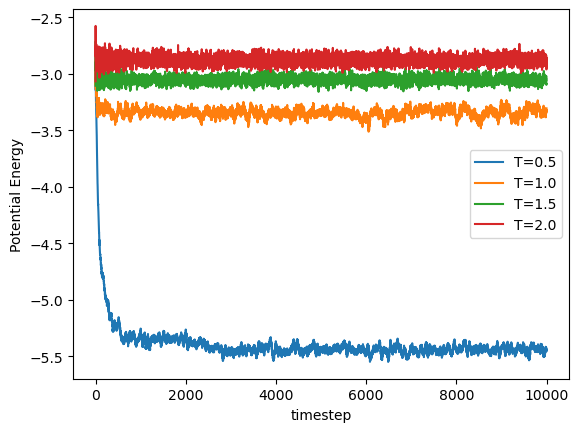

In [28]:
import matplotlib.pyplot as plt
for T, e in pe.items():
  plt.plot(numpy.array(e[0:])/N_particles, label=f'T={T}')
plt.xlabel('timestep')
plt.ylabel('Potential Energy')
plt.legend()

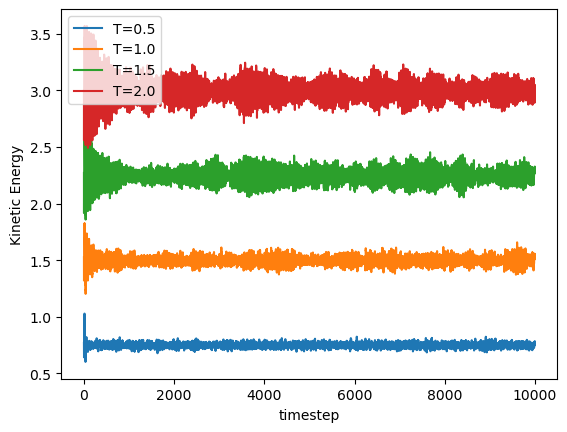

In [29]:
import matplotlib.pyplot as plt
for T, e in ke.items():
  plt.plot(numpy.array(e[0:])/N_particles, label=f'T={T}')
plt.xlabel('timestep')
plt.ylabel('Kinetic Energy')
plt.legend()

In [60]:
dt = 0.005
T = 0.8
N = [5,10,12,20,25,27]
pe = {}
ke = {}
for i in N:
  del simulation
  print(i)
  pe[f"{i}"] = []
  ke[f"{i}"] = []
  simulation = hoomd.Simulation(device = device, seed = seed)
  simulation.create_state_from_gsd(filename='initial_state_' + str(i) + '.gsd')
  integrator = hoomd.md.Integrator(dt = dt)
  nvt = hoomd.md.methods.NVT(filter = hoomd.filter.All(),kT=T,tau=100*dt)
  integrator.methods.append(nvt)
  cell = hoomd.md.nlist.Cell(buffer=0.4)

  #Define the force for different particles
  lj = hoomd.md.pair.LJ(nlist=cell)

  lj.params[('A', 'A')] = {"epsilon":epsilon, "sigma":sigma}

  lj.r_cut[('A', 'A')] = 2.5*sigma
  integrator.forces.append(lj)
  simulation.operations.integrator = integrator
  simulation.run(10)

  simulation.state.thermalize_particle_momenta(filter=hoomd.filter.All(), kT=T)
  thermodynamic_properties = hoomd.md.compute.ThermodynamicQuantities(
      filter=hoomd.filter.All()
  )

  simulation.operations.computes.append(thermodynamic_properties)
  logger = hoomd.logging.Logger(categories=['scalar', 'sequence'])
  logger.add(simulation)
  logger.add(thermodynamic_properties,quantities=['potential_energy'])
  tps_tracking = hoomd.logging.Logger(categories=['scalar', 'string'])
  tps_tracking.add(simulation, quantities=['timestep', 'tps'])
  table = hoomd.write.Table(trigger=hoomd.trigger.Periodic(period=int(1e4)), logger=tps_tracking)
  simulation.operations.writers.append(table)
  for step in range(10000):
      simulation.run(10)
      pe[f"{i}"].append(thermodynamic_properties.potential_energy)
      ke[f"{i}"].append(thermodynamic_properties.kinetic_energy)

5
Simulation.timestep  Simulation.tps 
       10000          20408.16327   
       20000          20930.23256   
       30000          21327.01422   
       40000          19736.84211   
       50000          19108.28025   
       60000          41860.46512   
       70000          20501.13895   
       80000          41474.65438   
       90000          19867.54967   
      100000          19911.50442   
10
Simulation.timestep  Simulation.tps 
       10000           1813.78476   
       20000           1817.44750   
       30000           1772.00236   
       40000           1801.08065   
       50000           1843.12922   
       60000           1834.11453   
       70000           1826.66937   
       80000           1828.15356   
       90000           1783.94450   
      100000           1860.27284   
12
Simulation.timestep  Simulation.tps 
       10000           1026.92834   
       20000           1029.15952   
       30000           1021.10279   
       40000           1025.29

-3.568573624479373
-4.108761754899395
-4.216939780386232
-4.442672312113508
-4.52484370033963
-4.537550433131334


Text(0, 0.5, 'Potential Energy')

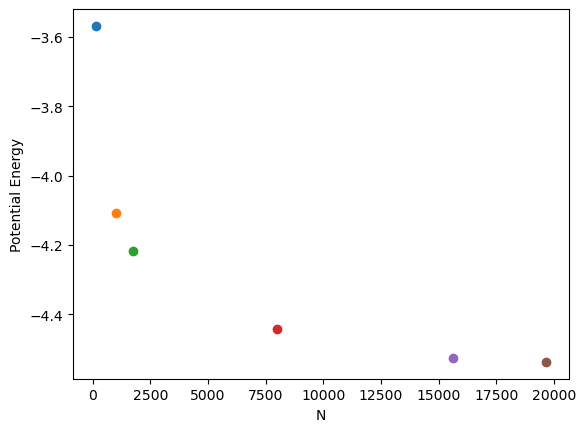

In [61]:
import matplotlib.pyplot as plt
for N, e in pe.items():
  print(numpy.mean(e[5000:])/(int(N)**3))
  plt.scatter(int(N)**3,numpy.mean(e[5000:])/(int(N)**3))
plt.xlabel('N')
plt.ylabel('Potential Energy')